## Problem Set 1: Gaussians and Visualization
### Made by Denis Fatykhoph

### Task 1: Probability
**A.** Plot the probability density function $ p(x) $ of a one dimensional Gaussian distribution $ \mathcal{N} (x; 1, 1) $ 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

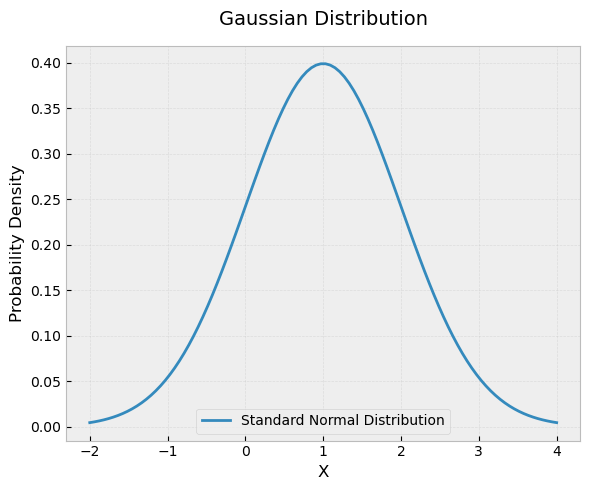

In [7]:
plt.style.use('bmh')  # or 'ggplot', 'bmh', 'classic'

x = np.linspace(-2, 4, 100)
dist_pdf = stats.norm.pdf(x , 1, 1)

plt.figure(figsize=(6, 5))
plt.plot(x, dist_pdf, linewidth=2, label='Standard Normal Distribution')

plt.title('Gaussian Distribution', fontsize=14, pad=15)
plt.xlabel('X', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

**B.** Calculate the probability mass that the random variable $ X $ is less than $ 0 $, that is, $Pr \left\{ X \le 0 \right\} = \int_{-\infty}^{0} p(x) dx$

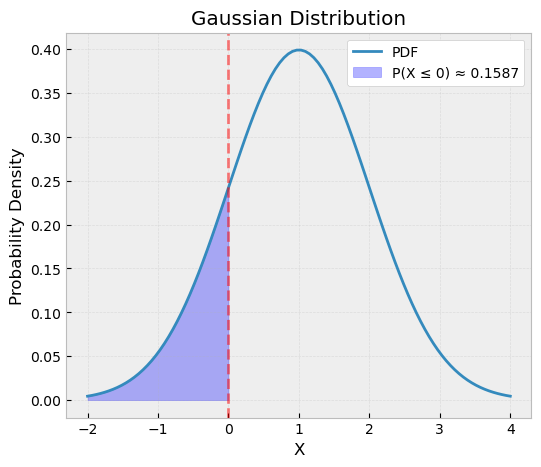

In [19]:
probability = stats.norm.cdf(0, loc=1, scale=1)

plt.figure(figsize=(6, 5))
plt.plot(x, dist_pdf, label='PDF')

# Shade the area for X ≤ 0
mask = x <= 0
plt.fill_between(x[mask], dist_pdf[mask], color='blue', alpha=0.3, 
                 label=f'P(X ≤ 0) ≈ {probability:.4f}')

# Vertical line at x=0
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)

plt.title('Gaussian Distribution')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True, alpha=0.3)
plt.legend(facecolor='white', framealpha=1)
plt.show()

**C.** Consider the new observation variable $ z $, it gives information about the variable $ x $ by the likelihood function $ p(z|x) = \mathcal{N} \left( z; x, \sigma^2 \right) $, with variance $ \sigma^2 = 0.2 $. Apply the Bayes’ theorem to derive the posterior distribution, $ p(x|z) $, given an observation $ z = 0.75 $ and plot it. For a better comparison, plot the prior distribution, $ p(x) $, too.

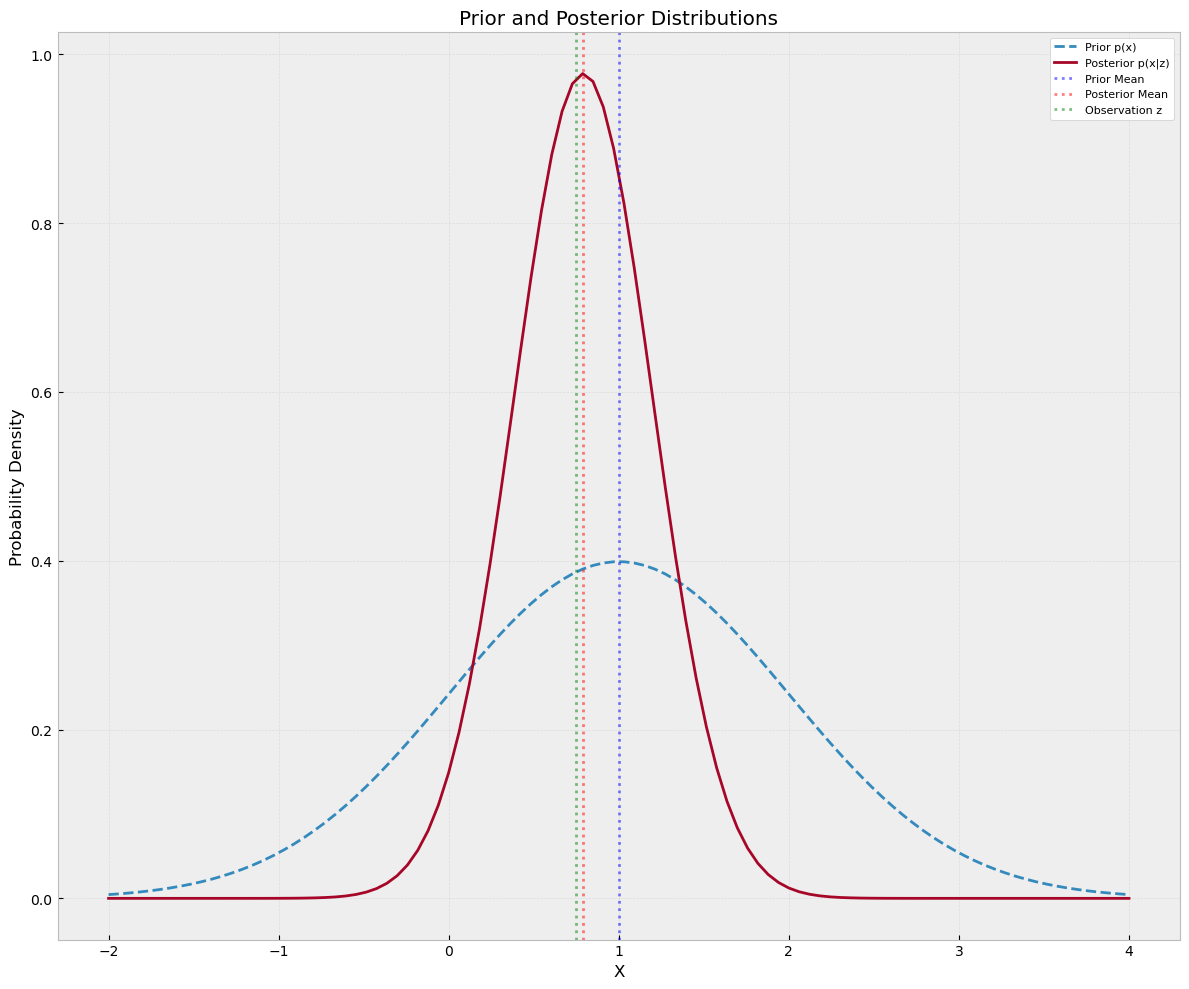

In [21]:
# Parameters
z = 0.75
sigma_z = 0.2
prior_mean = 1
prior_var = 1

# Bayes theorem
posterior_var = 1 / (1/prior_var + 1/sigma_z)
posterior_mean = posterior_var * (prior_mean/prior_var + z/sigma_z)

# Calculate PDFs
prior_pdf = stats.norm.pdf(x, prior_mean, np.sqrt(prior_var))
posterior_pdf = stats.norm.pdf(x, posterior_mean, np.sqrt(posterior_var))

plt.figure(figsize=(12, 10))
plt.plot(x, prior_pdf, label='Prior p(x)', linestyle='--')
plt.plot(x, posterior_pdf, label='Posterior p(x|z)')

plt.axvline(x=prior_mean, color='blue', linestyle=':', alpha=0.5, label='Prior Mean')
plt.axvline(x=posterior_mean, color='red', linestyle=':', alpha=0.5, label='Posterior Mean')
plt.axvline(x=z, color='green', linestyle=':', alpha=0.5, label='Observation z')

plt.title('Prior and Posterior Distributions')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True, alpha=0.3)
plt.legend(facecolor='white', framealpha=1, fontsize=8)
plt.tight_layout()
plt.show()
